In [4]:
import sys
sys.path.append('../modules')
from sklearn.metrics import cohen_kappa_score, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from krippendorff import alpha as krippendorff_alpha
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from seeDistinctValues import seeDistinctValues
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
import numpy as np

df = pd.read_csv('merged_checked.csv')

# Remove column 'Q1.7.1.2' because of the answer is a word
df = df.drop(columns=['Q1.7.1.2'])


In [5]:
df

,id,title,annotator,Q1.1,Q1.2,Q1.3,Q1.3.1,Q1.4,Q1.5,Q1.6,Q1.7,Q1.7.1
0,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Manuel,3,2,31,-1,2,4,4,1,0
1,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Angelo,3,3,10,1,1,4,4,1,0
2,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Israele: Lapid| ostacoli ma fiducioso su nuovo...,Manuel,3,4,10,-1,2,4,4,1,0
3,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Israele: Lapid| ostacoli ma fiducioso su nuovo...,Marinella,3,4,10,-1,1,4,4,2,5
4,34b92f4c-32db-454c-a369-ca2032443f6c,Le borsette fatte a 3 euro l'ora vendute a 820...,Manuel,2,3,31,-1,1,3,2,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...
811,5717ce3e-69a2-4e5a-8e70-2f8230c217ad,Laura Pausini e le Lady Oscar italiane: «Devo ...,ChatGPT4AsAnnotator,6,4,0,-1,1,4,4,1,0
812,89ab0d13-b200-474f-922f-e78cd70f7e40,Il ddl Zan serve per contrastare l’omotransfob...,ChatGPT4AsAnnotator,3,4,11,-1,1,2,2,2,0
813,0c834cb0-392a-4a5e-948f-237a2c8bef31,La madre della neonata salvata in mare: «Chied...,ChatGPT4AsAnnotator,6,4,1,-1,1,4,4,1,0
814,966f95b9-fc3d-4950-bbc4-0ce1e07c6873,"Pestaggi in carcere, ex detenuto sulla sedia a...",ChatGPT4AsAnnotator,6,4,0,2,1,4,4,2,0


In [6]:
seeDistinctValues(df)

Colonna Q1.1:
[3 2 4 1 5 0 6 7]
Colonna Q1.2:
[ 2  3  4  1 -1]
Colonna Q1.3:
[31 10 37 15 11 20 40 32  1 44  0 19 28 23  6  3 17 26 14  5 13 34  2 16
 33 42 30 24 39 43 36 35 38 41 29  9 21 12  4  8 18  7 22 25 27]
Colonna Q1.3.1:
[-1  1  2]
Colonna Q1.4:
[ 2  1 -1]
Colonna Q1.5:
[ 4  3  2  1 -1]
Colonna Q1.6:
[ 4  2  3  1 -1]
Colonna Q1.7:
[ 1  2 -1]
Colonna Q1.7.1:
[ 0  5 13  7  1  2 18 12 14  8  6 15  9  3 19 20 17 21 16  4 11 10]


# Comparison

# Kappa

In [7]:
from sklearn.metrics import cohen_kappa_score

# Per ciascun articolo condiviso, calcola il coefficiente Kappa di Cohen
def getKappa(annotator_1, annotator_2):
    # Inizializza una lista per memorizzare i coefficienti Kappa di Cohen
    kappa_scores = []

    articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
        set(df[df['annotator'] == annotator_2]['id']))
    
    for article_id in articles:
        annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][['Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7']]
        annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][['Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7']]

        # Flatten the DataFrame to a 1D array
        annotator1_values = annotator1.values.flatten()
        annotator2_values = annotator2.values.flatten()

        # Exclude -1 values
        mask = (annotator1_values != -1) & (annotator2_values != -1)
        annotator1_values = annotator1_values[mask]
        annotator2_values = annotator2_values[mask]

        if len(annotator1_values) > 0 and len(annotator2_values) > 0:
            # Calculate Cohen's Kappa
            k = cohen_kappa_score(annotator1_values, annotator2_values)
            kappa_scores.append(k)

    if len(kappa_scores) > 0:
        mean_kappa = sum(kappa_scores) / len(kappa_scores)
        print('Il K tra ' + str(annotator_1) + ' e ' + str(annotator_2) + ' è di: ' + str(mean_kappa))
        return mean_kappa
    else:
        print('Non ci sono annotazioni in comune tra gli annotatori ' + str(annotator_1) + ' e ' + str(annotator_2))
        return None

# Esempi di utilizzo
out = getKappa('Manuel', 'Angelo')
out = getKappa('Manuel', 'Marinella')
out = getKappa('Angelo', 'Marinella')

print('------------------------------------------')
print('------------------------------------------')

out = getKappa('ChatGPT4AsAnnotator', 'Marinella')
out = getKappa('ChatGPT4AsAnnotator', 'Angelo')
out = getKappa('ChatGPT4AsAnnotator', 'Manuel')


/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:708: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Il K tra Manuel e Angelo è di: nan
Il K tra Manuel e Marinella è di: 0.6313784673985696
Il K tra Angelo e Marinella è di: 0.6703015515012851
------------------------------------------
------------------------------------------


/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:708: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Il K tra ChatGPT4AsAnnotator e Marinella è di: nan
Il K tra ChatGPT4AsAnnotator e Angelo è di: 0.47837060664485836
Il K tra ChatGPT4AsAnnotator e Manuel è di: 0.5252520569840925


# Mertiche classiche considerando uno degli annotatori come ground truth

In [8]:
def calculate_metrics_per_column(annotator_1, annotator_2, df):
    filtered_df = df[df['annotator'].isin([annotator_1, annotator_2])]
    ids_annotator_1 = filtered_df[filtered_df['annotator'] == annotator_1]['id']
    ids_annotator_2 = filtered_df[filtered_df['annotator'] == annotator_2]['id']
    common_ids = ids_annotator_1[ids_annotator_1.isin(ids_annotator_2)]
    df = filtered_df[filtered_df['id'].isin(common_ids)]

    gpt_df = df[df['annotator'] == annotator_2]
    human_df = df[df['annotator'] == annotator_1]

    results = {}

    merged_data = pd.merge(gpt_df, human_df, on="id", suffixes=("_gpt", "_human"))

    columns_of_interest = [ "Q1.2", "Q1.3.1", "Q1.4", "Q1.5", "Q1.6", "Q1.7"]

    plt.subplots_adjust(top=10)

    for col in columns_of_interest:
        y_gpt = merged_data[col + "_gpt"]
        y_human = merged_data[col + "_human"]

        # Filter out cases where either annotator has value -1
        valid_indices = (y_gpt != -1) & (y_human != -1)
        y_gpt = y_gpt[valid_indices]
        y_human = y_human[valid_indices]

        if len(y_gpt) == 0:
            continue  # Skip this column if there are no valid annotations
        
        # Baseline "most_frequent" (as you already have)
        baseline_model_most_frequent = DummyClassifier(strategy="most_frequent")
        # Filtering human_df based on the IDs present in merged_data with valid indices
        baseline_model_most_frequent.fit(human_df.loc[human_df['id'].isin(merged_data.loc[valid_indices, 'id']), [col]], y_human)
        y_pred_baseline_most_frequent = baseline_model_most_frequent.predict(human_df.loc[human_df['id'].isin(merged_data.loc[valid_indices, 'id']), [col]])

        # Baseline "stratified"
        baseline_model_stratified = DummyClassifier(strategy="stratified")
        # Same filtering for stratified baseline model
        baseline_model_stratified.fit(human_df.loc[human_df['id'].isin(merged_data.loc[valid_indices, 'id']), [col]], y_human)
        y_pred_baseline_stratified = baseline_model_stratified.predict(human_df.loc[human_df['id'].isin(merged_data.loc[valid_indices, 'id']), [col]])

        balanced_acc = balanced_accuracy_score(y_human, y_gpt)
        f1_micro = f1_score(y_human, y_gpt, average='micro')
        f1_macro = f1_score(y_human, y_gpt, average='macro')
        f1_avg = f1_score(y_human, y_gpt, average='weighted')

        balanced_acc_baseline_most_frequent = balanced_accuracy_score(y_human, y_pred_baseline_most_frequent)
        f1_micro_baseline_most_frequent = f1_score(y_human, y_pred_baseline_most_frequent, average='micro')
        f1_macro_baseline_most_frequent = f1_score(y_human, y_pred_baseline_most_frequent, average='macro')
        f1_avg_baseline_most_frequent = f1_score(y_human, y_pred_baseline_most_frequent, average='weighted')

        balanced_acc_baseline_stratified = balanced_accuracy_score(y_human, y_pred_baseline_stratified)
        f1_micro_baseline_stratified = f1_score(y_human, y_pred_baseline_stratified, average='micro')
        f1_macro_baseline_stratified = f1_score(y_human, y_pred_baseline_stratified, average='macro')
        f1_avg_baseline_stratified = f1_score(y_human, y_pred_baseline_stratified, average='weighted')

        results[col] = {
            'balanced_accuracy': balanced_acc,
            'f1_micro': f1_micro,
            'f1_macro': f1_macro,
            'f1_avg': f1_avg,
            'baseline_most_frequent_balanced_accuracy': balanced_acc_baseline_most_frequent,
            'baseline_most_frequent_f1_micro': f1_micro_baseline_most_frequent,
            'baseline_most_frequent_f1_macro': f1_macro_baseline_most_frequent,
            'baseline_most_frequent_f1_avg': f1_avg_baseline_most_frequent,
            'baseline_stratified_balanced_accuracy': balanced_acc_baseline_stratified,
            'baseline_stratified_f1_micro': f1_micro_baseline_stratified,
            'baseline_stratified_f1_macro': f1_macro_baseline_stratified,
            'baseline_stratified_f1_avg': f1_avg_baseline_stratified
        }
    num_cols = len(columns_of_interest)
    num_plots_per_row = 3
    num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

    fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(18, 4*num_rows))

    for i, col in enumerate(columns_of_interest):
        metrics = results[col]

        labels = ['Bal. Accuracy', 'F1 Micro', 'F1 Macro', 'F1 Weighted']
        model_values = [metrics['balanced_accuracy'], metrics['f1_micro'], metrics['f1_macro'], metrics['f1_avg']]
        baseline_values_most_frequent = [metrics['baseline_most_frequent_balanced_accuracy'], metrics['baseline_most_frequent_f1_micro'],
                                         metrics['baseline_most_frequent_f1_macro'], metrics['baseline_most_frequent_f1_avg']]
        baseline_values_stratified = [metrics['baseline_stratified_balanced_accuracy'], metrics['baseline_stratified_f1_micro'],
                                      metrics['baseline_stratified_f1_macro'], metrics['baseline_stratified_f1_avg']]

        row_idx = i // num_plots_per_row
        col_idx = i % num_plots_per_row

        x = np.arange(len(labels))
        width = 0.25

        axs[row_idx, col_idx].bar(x - width, model_values, width, label='Model')
        axs[row_idx, col_idx].bar(x, baseline_values_most_frequent, width, label='Baseline (most frequent)')
        axs[row_idx, col_idx].bar(x + width, baseline_values_stratified, width, label='Baseline (stratified)')

        for j, (v, b1, b2) in enumerate(zip(model_values, baseline_values_most_frequent, baseline_values_stratified)):
            offset = 0
            axs[row_idx, col_idx].text(x[j] - width + offset, v + 0.01, f"{v:.4f}", ha='center', fontsize=7)
            axs[row_idx, col_idx].text(x[j], b1 + 0.01, f"{b1:.4f}", ha='center', fontsize=7)
            axs[row_idx, col_idx].text(x[j] + width + offset, b2 + 0.01, f"{b2:.4f}", ha='center', fontsize=7)

        axs[row_idx, col_idx].set_ylabel('Score')
        axs[row_idx, col_idx].set_title(f'Metrics for {col}')
        axs[row_idx, col_idx].set_xticks(x)
        axs[row_idx, col_idx].set_xticklabels(labels)
        axs[row_idx, col_idx].legend()
        axs[row_idx, col_idx].set_ylim(0, 1.07)

    for i in range(num_rows * num_plots_per_row):
        if i >= num_cols:
            axs.flatten()[i].axis('off')

    plt.tight_layout()
    plt.show()


<Figure size 640x480 with 0 Axes>

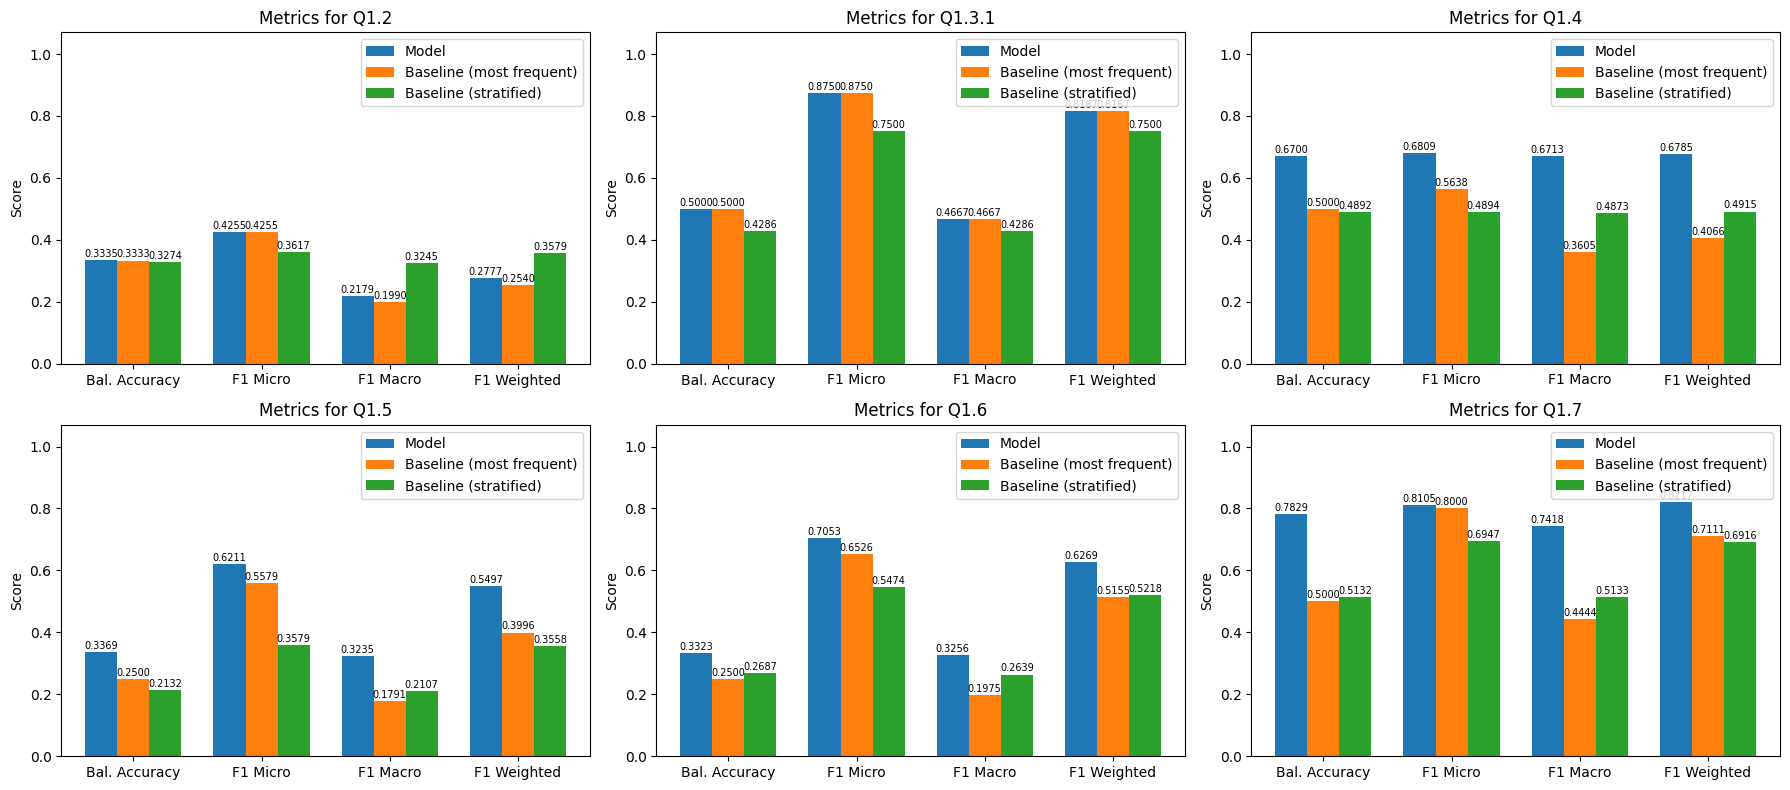

In [9]:
calculate_metrics_per_column('Manuel', 'ChatGPT4AsAnnotator', df)

/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


<Figure size 640x480 with 0 Axes>

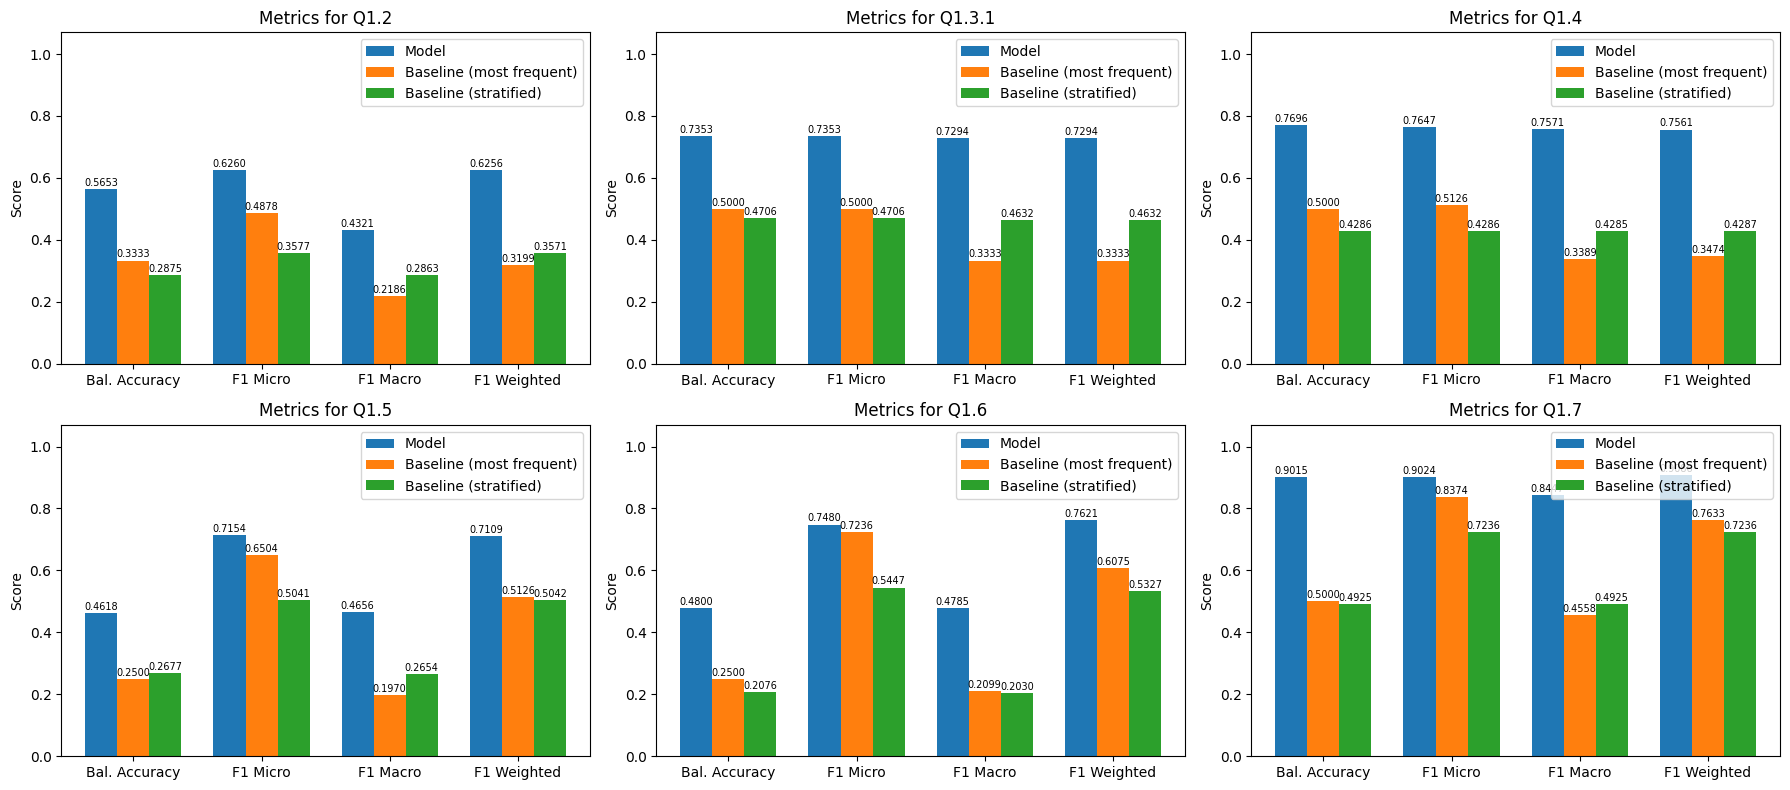

In [10]:
calculate_metrics_per_column('Manuel', 'Marinella', df)

<Figure size 640x480 with 0 Axes>

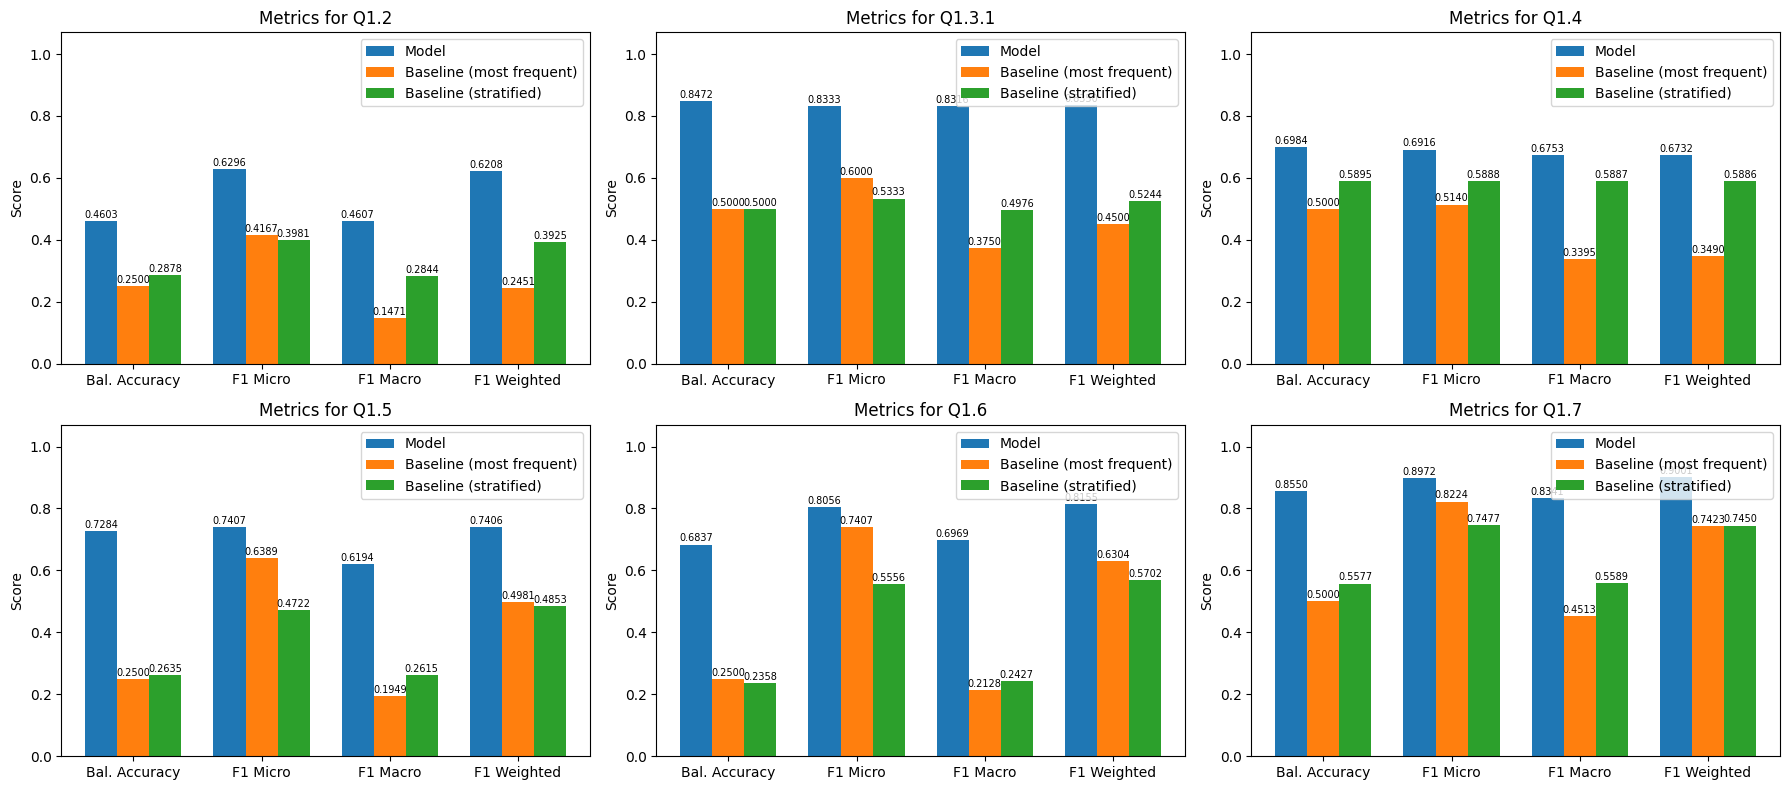

In [11]:
calculate_metrics_per_column('Manuel', 'Angelo', df)

# Metriche classiche ma con le domande per grado semplificate (2 classi anziché 4) per le domande 1.2, 1.6 e 1.5

In [9]:
def semplify_column(column):
  """
  Trasforma una colonna in base alle condizioni specificate.

  Args:
    column: La colonna da trasformare (serie Pandas).

  Returns:
    La colonna trasformata (serie Pandas).
  """
  
  column = column.copy()
  column[column < 3] = 1
  column[column > 2] = 2
  return column


semplified_df = df

semplified_df["Q1.2"] = semplify_column(semplified_df["Q1.2"])
semplified_df["Q1.5"] = semplify_column(semplified_df["Q1.5"])
semplified_df["Q1.6"] = semplify_column(semplified_df["Q1.6"])


In [10]:
semplified_df

,id,title,label,annotator,Q1.1,Q1.2,Q1.3,Q1.3.1,Q1.4,Q1.5,Q1.6,Q1.7,Q1.7.1,Q2.8,Q2.9.1,Q2.10
0,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Group 2,Manuel,1,1,31,-1,2,2,2,1,0,1,2,2
1,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Group 2,Angelo,1,2,10,1,1,2,2,1,0,1,2,2
2,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Israele: Lapid| ostacoli ma fiducioso su nuovo...,Group 2,Manuel,1,2,10,-1,2,2,2,1,0,3,2,2
3,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Israele: Lapid| ostacoli ma fiducioso su nuovo...,Group 2,Marinella,1,2,10,-1,1,2,2,2,5,3,2,2
4,34b92f4c-32db-454c-a369-ca2032443f6c,Le borsette fatte a 3 euro l'ora vendute a 820...,Group 1,Manuel,2,2,31,-1,1,2,1,2,5,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,95357073-ff48-47ab-a0ad-62324150033a,L’imprenditore che produce monoclonali a Latin...,Group 1,ChatGPT4AsAnnotator,3,2,1,2,2,2,2,1,1,3,2,2
1011,d30b11b6-a665-438c-8ee2-12ea175daeb5,"I nuovi colori da lunedì 17 maggio, l’ordinanz...",Group 1,ChatGPT4AsAnnotator,1,2,1,2,2,2,2,1,0,3,2,2
1012,abe99528-6405-4ebb-9b2f-2e76fb08ac53,Anche le Carresi inseguono la Zona Bianca,Group 2,ChatGPT4AsAnnotator,3,2,1,2,2,2,2,1,1,3,2,1
1013,8633735e-f183-4d8e-a1e7-9d49b1a2a7b4,Le stoccate di Draghi per infilzare Conte,Group 1,ChatGPT4AsAnnotator,2,2,1,2,2,1,1,2,11,3,2,1


/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


<Figure size 640x480 with 0 Axes>

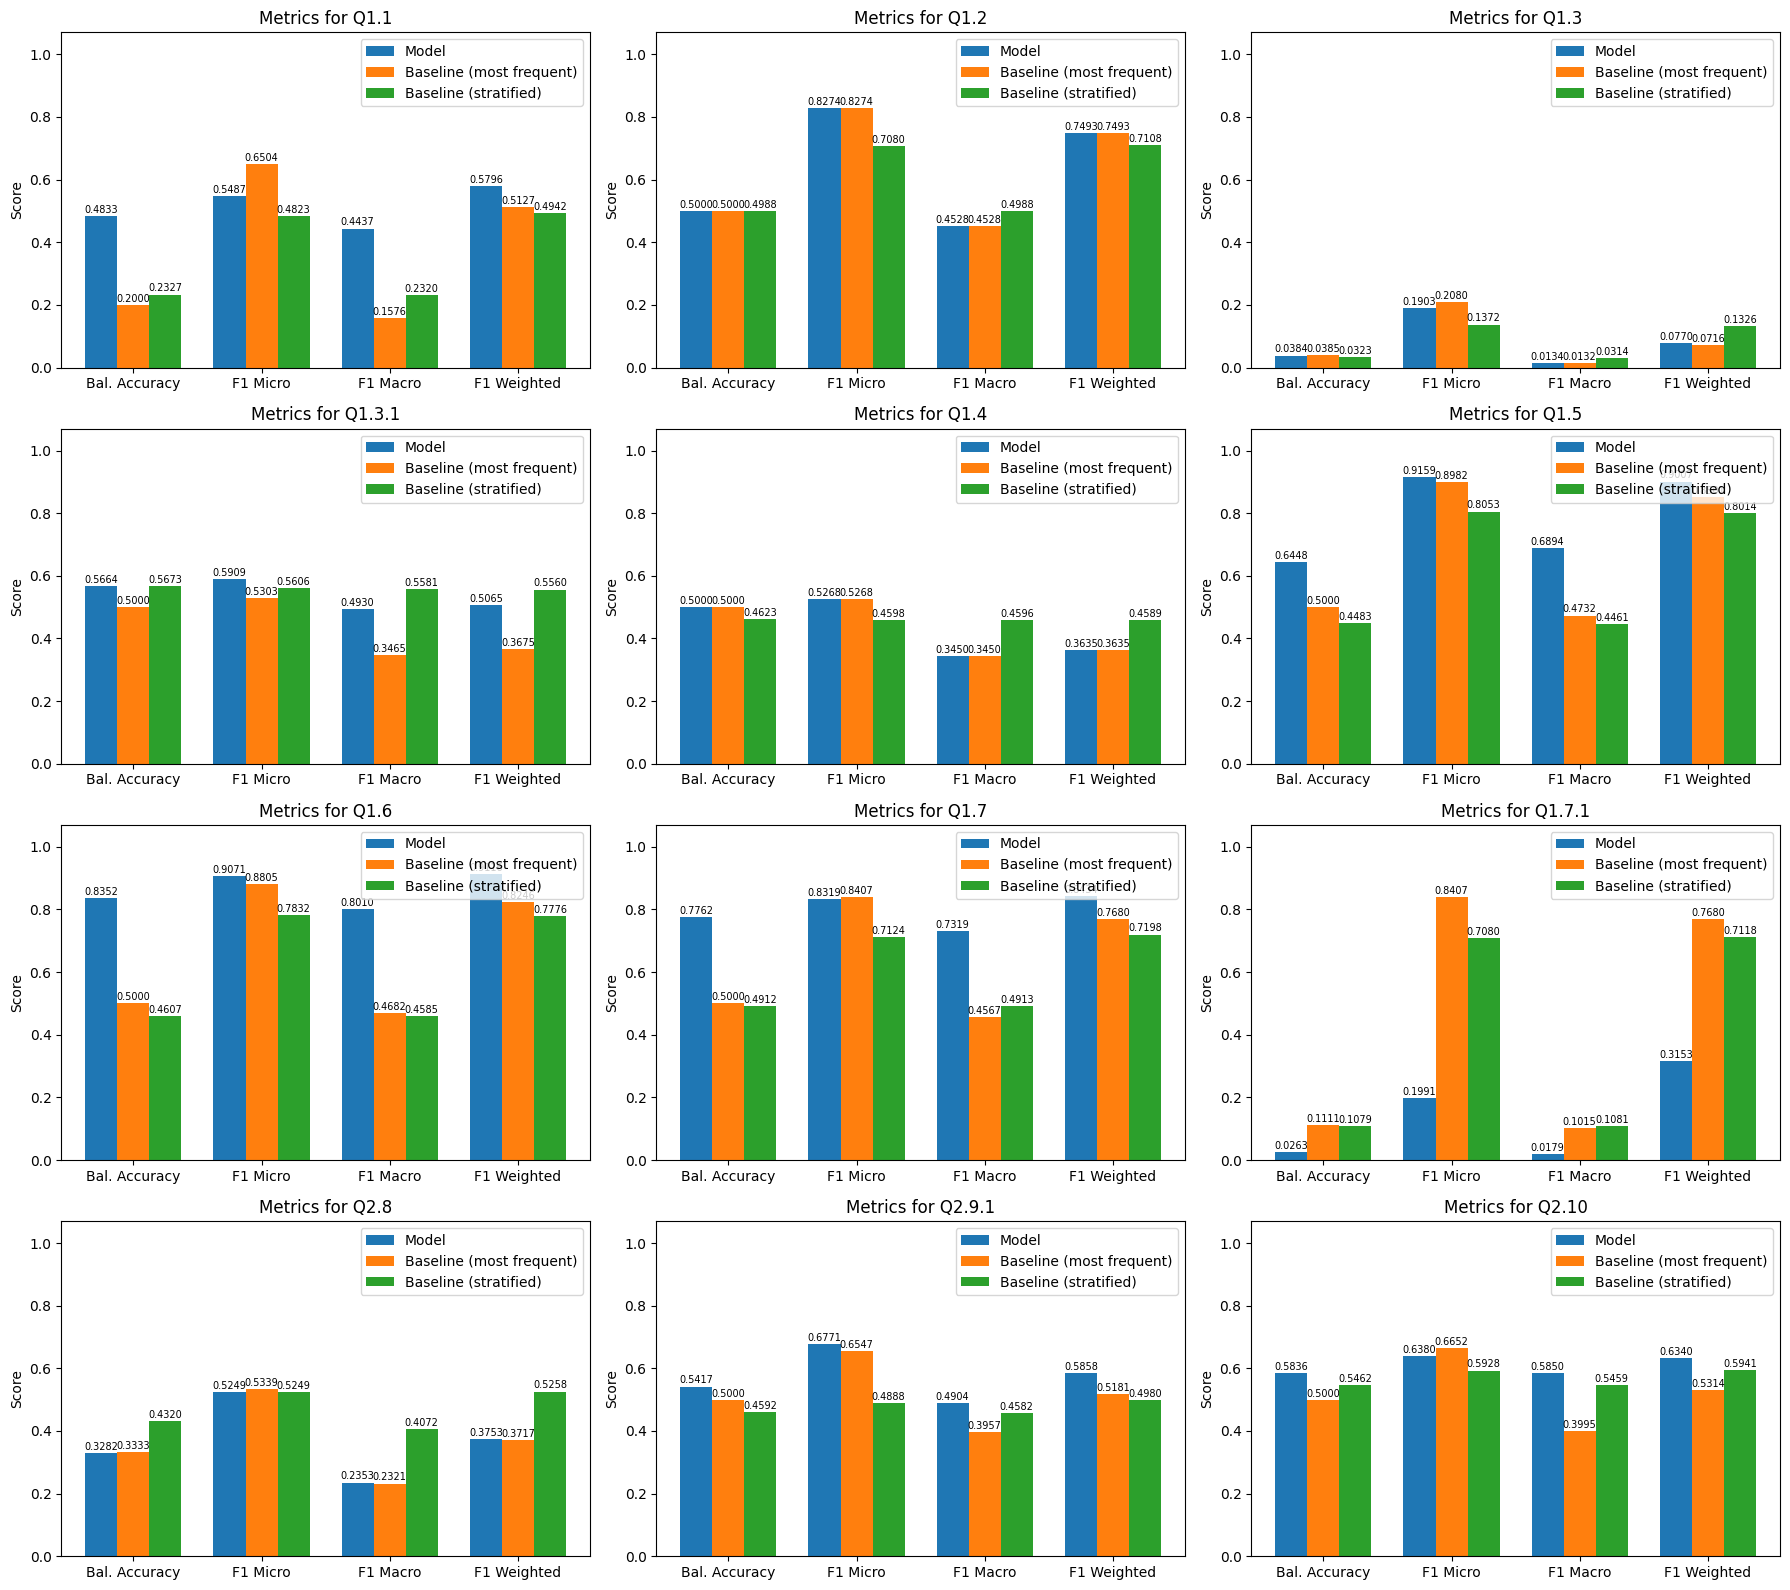

In [11]:
calculate_metrics_per_column('Manuel', 'ChatGPT4AsAnnotator', semplified_df)


 
 # Matrici di confusione solo per i valori inseriti

Manuel VS ChatGPT4AsAnnotator


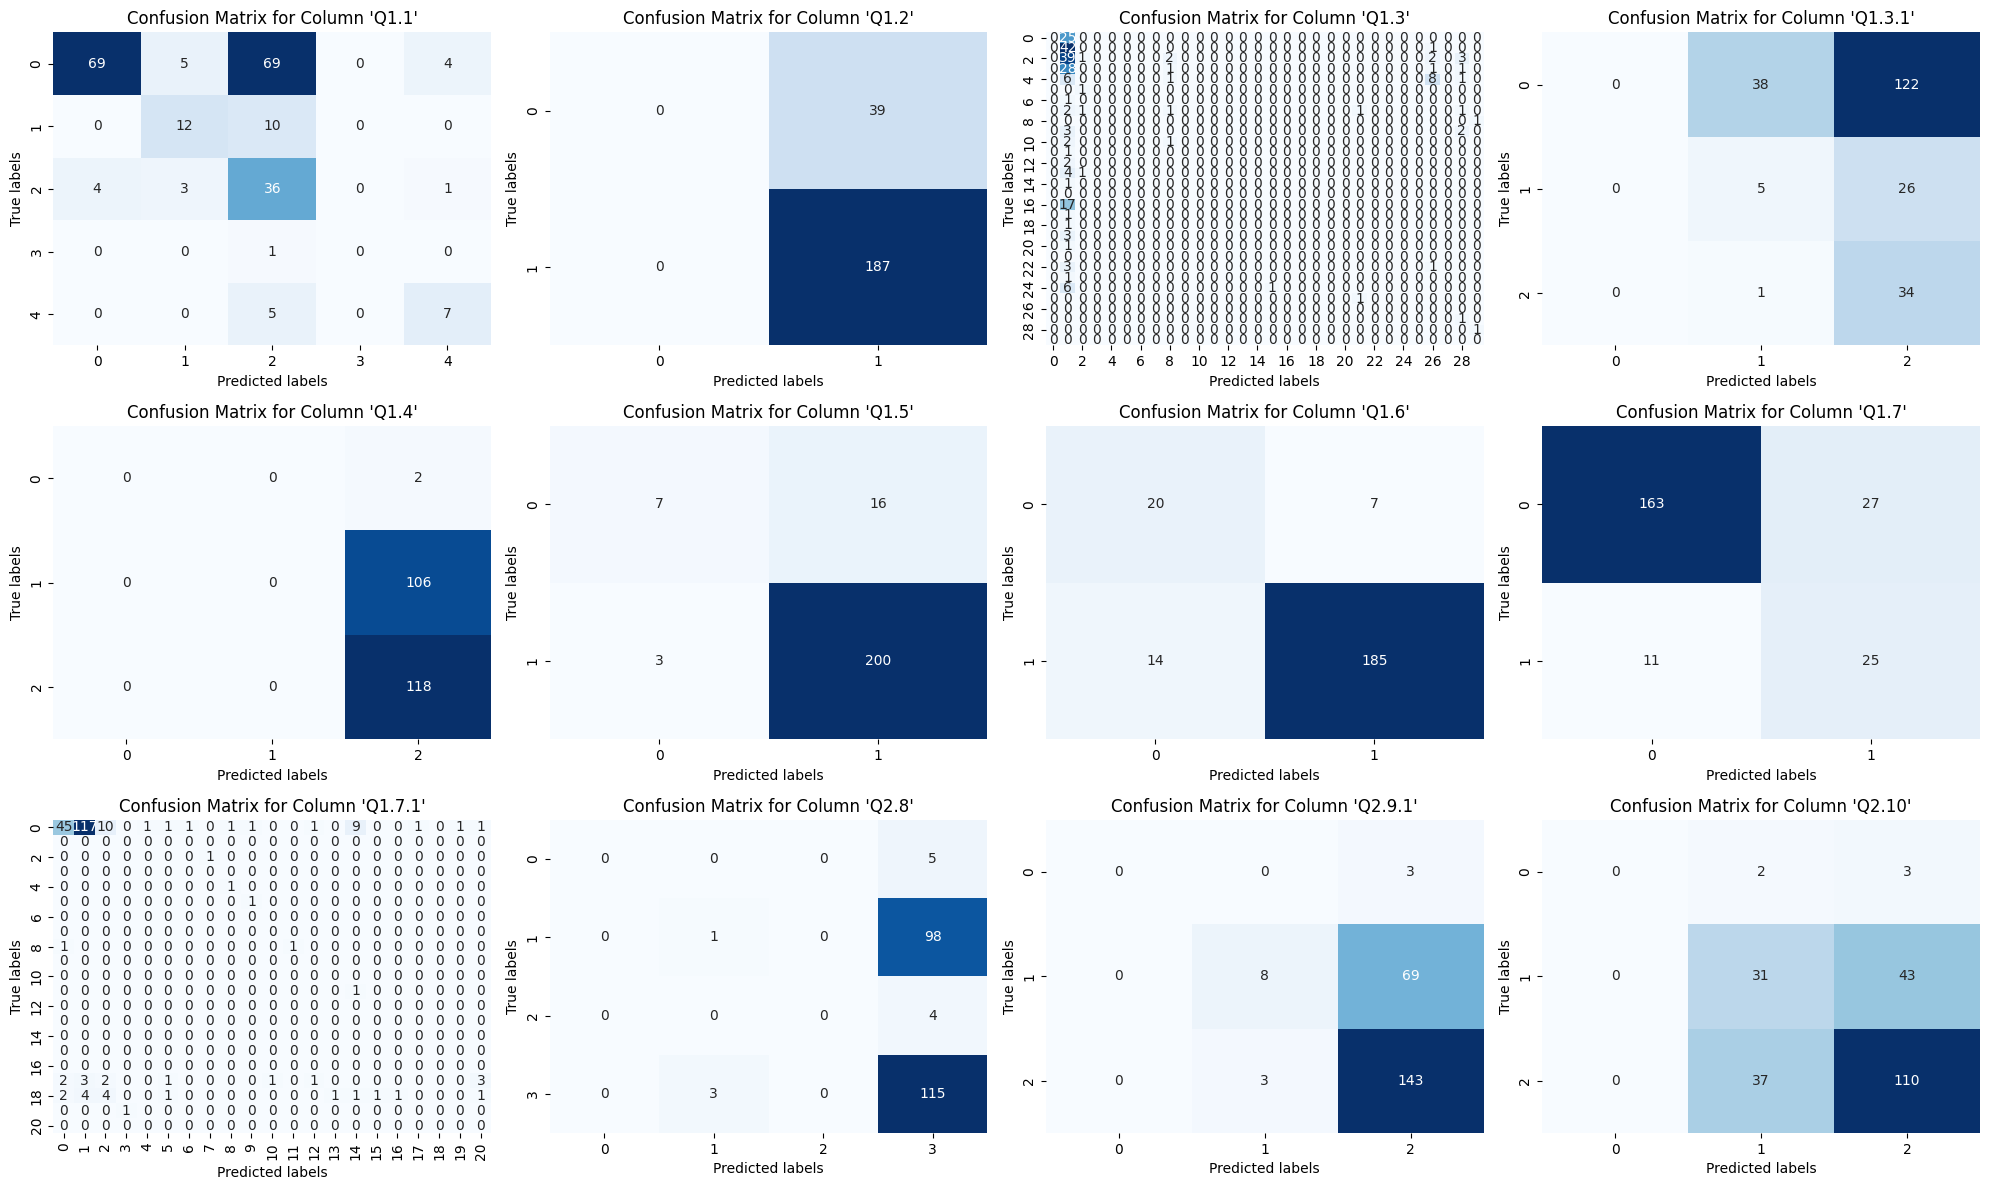

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def calculate_confusion_matrix(annotator_1, annotator_2, columns):
    confusion_matrices = {}
    for column in columns:
        y_true = []
        y_pred = []

        articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
            set(df[df['annotator'] == annotator_2]['id']))

        for article_id in articles:
            annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][[column]]
            annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][[column]]

            annotator1 = annotator1.astype(str)
            annotator2 = annotator2.astype(str)

            for col in annotator1.columns:
                annotations_1 = annotator1[col].values.flatten()
                annotations_2 = annotator2[col].values.flatten()
                for ann_1, ann_2 in zip(annotations_1, annotations_2):
                    y_true.append(ann_1)
                    y_pred.append(ann_2)

        confusion_matrices[column] = confusion_matrix(y_true, y_pred)
    plot_confusion_matrices(confusion_matrices)
    return 0

def plot_confusion_matrices(conf_matrices):
    num_cols = len(conf_matrices)
    num_rows = int(np.ceil(num_cols / 4))  # Calcola il numero di righe necessarie per mostrare 4 matrici per riga
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))

    for i, (column, conf_matrix) in enumerate(conf_matrices.items()):
        row = i // 4  # Calcola la riga corrente
        col = i % 4   # Calcola la colonna corrente
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[row, col])
        axes[row, col].set_xlabel("Predicted labels")
        axes[row, col].set_ylabel("True labels")
        axes[row, col].set_title(f"Confusion Matrix for Column '{column}'")

    plt.tight_layout()
    plt.show()

columns_to_consider = ["Q1.1", "Q1.2", "Q1.3", "Q1.3.1", "Q1.4", "Q1.5", "Q1.6", "Q1.7", "Q1.7.1", "Q2.8", "Q2.9.1", "Q2.10"]
print('Manuel VS ChatGPT4AsAnnotator')
conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider)


# Matrici di confusione considerando tutti i valori possibili per ogni risposta

Manuel VS ChatGPT4AsAnnotator


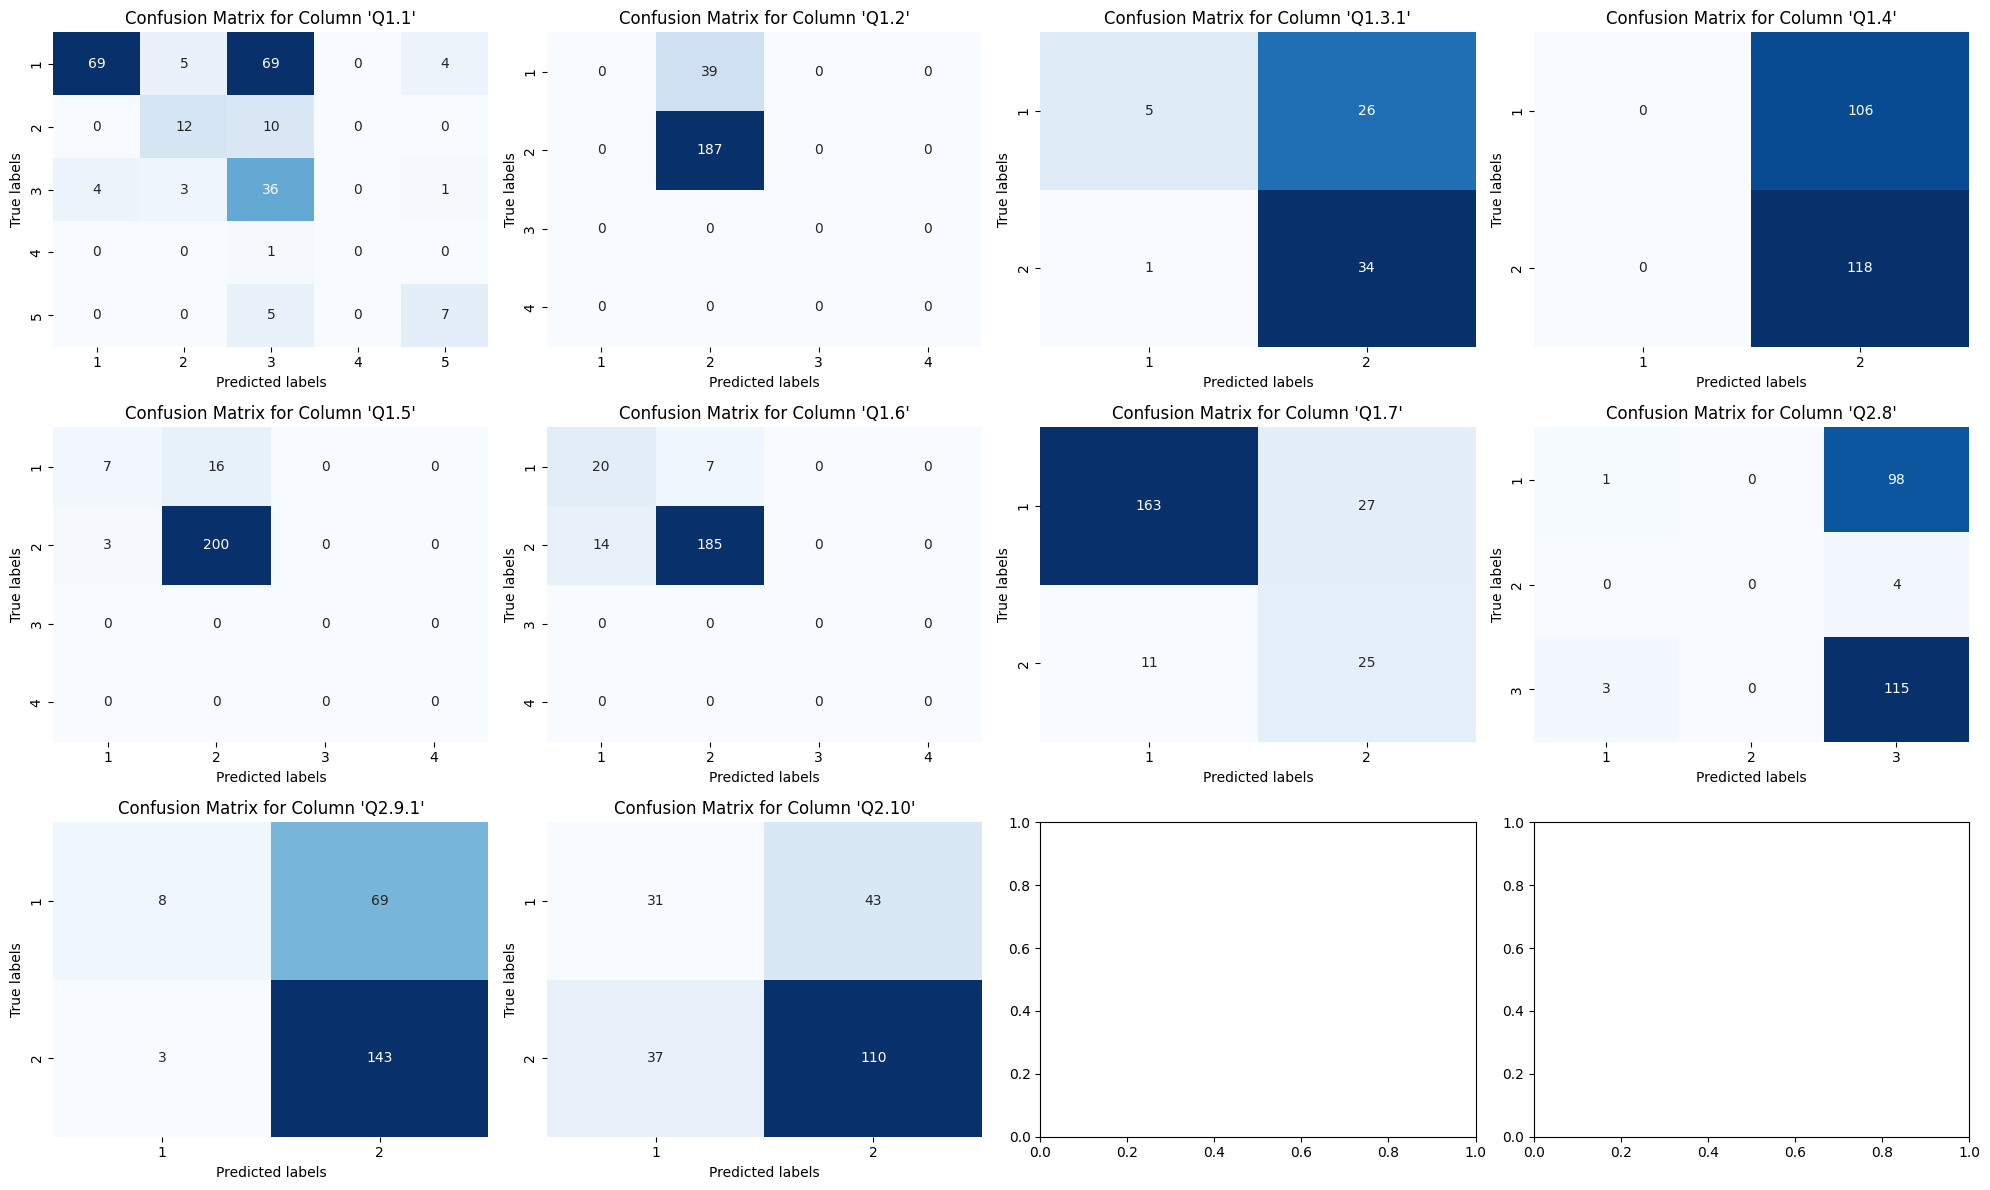

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def calculate_confusion_matrix(annotator_1, annotator_2, columns, possible_values):
    confusion_matrices = {}
    for column in columns:
        y_true = []
        y_pred = []

        articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
            set(df[df['annotator'] == annotator_2]['id']))

        for article_id in articles:
            annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][[column]]
            annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][[column]]

            annotator1 = annotator1.astype(str)
            annotator2 = annotator2.astype(str)

            for col in annotator1.columns:
                annotations_1 = annotator1[col].values.flatten()
                annotations_2 = annotator2[col].values.flatten()
                for ann_1, ann_2 in zip(annotations_1, annotations_2):
                    y_true.append(ann_1)
                    y_pred.append(ann_2)

        confusion_matrices[column] = confusion_matrix(y_true, y_pred, labels=possible_values[column])
    plot_confusion_matrices(confusion_matrices, possible_values)
    return 0

def plot_confusion_matrices(conf_matrices, possible_values):
    num_cols = len(conf_matrices)
    num_rows = int(np.ceil(num_cols / 4))
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))

    for i, (column, conf_matrix) in enumerate(conf_matrices.items()):
        row = i // 4
        col = i % 4
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[row, col], 
                    xticklabels=possible_values[column], yticklabels=possible_values[column])
        axes[row, col].set_xlabel("Predicted labels")
        axes[row, col].set_ylabel("True labels")
        axes[row, col].set_title(f"Confusion Matrix for Column '{column}'")

    plt.tight_layout()
    plt.show()

columns_to_consider = ["Q1.1", "Q1.2", "Q1.3.1", "Q1.4", "Q1.5", "Q1.6", "Q1.7", "Q2.8", "Q2.9.1", "Q2.10"]
possible_values = {
    'Q1.1': ['1', '2', '3', '4', '5'], 
    'Q1.2': ['1', '2', '3', '4'],
    'Q1.3.1': ['1', '2'],
    'Q1.4': ['1', '2'],
    'Q1.5': ['1', '2', '3', '4'],
    'Q1.6': ['1', '2', '3', '4'],
    'Q1.7': ['1', '2'],
    'Q2.8': ['1', '2', '3'],
    'Q2.9.1': ['1', '2'],
    'Q2.10': ['1', '2']
}

print('Manuel VS ChatGPT4AsAnnotator')
conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider, possible_values)
